## additional analysis between kafka and data warehouse
---

Two goals:
* fix time, and find nr of differences between two dbs
* see if there is pattern to the differences"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdsutils

### Fix datetime
---

Since we had already queried all available kafka transactions, let's just use this.

The following query was carried out in notebook 904-1. Simply load it back!

```python
athena = mdsutils.AthenaClient("datalake_production_kafka_raw")

trnx_query = """
select k.value,
       k.offset,
       k.partition
from "datalake_production_kafka_raw"."com_sofi_banking_schemas_bankingtransactionoccurred" k
"""

trnx = athena.query_to_df(trnx_query)


import re

# amount pattern
fields = ["amount", "partyid", "transactioncode", "transeq", "isdebit", 
         "localdate", "primarypartyid", "accountnum", "accountbalance",
          "transactiontype", "isvault", "vaultendbalance", "authid"]

df = trnx

for f in fields:
    p = f"[^a-zA-Z0-9]{f}=([a-zA-Z0-9.-]+)"
    print(f, p)

    pattern = re.compile(p)
    df[f] = df["value"].str.extract(fr'{p}')
    
df.to_parquet("../../artifacts/data-dump/kafka-trnx-01102022-processed.parquet")
```

In [3]:
kafka_path = "../../artifacts/data-dump/kafka-trnx-01102022-processed.parquet"
kafka_df = pd.read_parquet(kafka_path)

In [5]:
# lets extract transeq and histseq as well!
import re

fields = ["histseq"]

for f in fields:
    p = f"[^a-zA-Z0-9]{f}=([a-zA-Z0-9.-]+)"
    print(f, p)

    pattern = re.compile(p)
    kafka_df[f] = kafka_df["value"].str.extract(fr'{p}')

kafka_df.to_parquet("../../artifacts/data-dump/kafka-trnx-01172022-processed.parquet")

histseq [^a-zA-Z0-9]histseq=([a-zA-Z0-9.-]+)


In [6]:
kafka_df["transeq"].isna().value_counts()

False    71290593
Name: transeq, dtype: int64

In [7]:
kafka_df["histseq"].isna().value_counts()

False    71290593
Name: histseq, dtype: int64

#### get dw data

In [40]:
%%time

from rdsutils.query import query_postgres

query = """
-- banking transactions by business account.
SELECT tjd,
       dtj.time,
       dtj.cid AS business_account_number,
       cdt AS created_dt,
       endbal,
       dtj.etc AS transaction_code,
       tamt AS amount,
       split_part(split_part(dtj.tso, 'AUTHID#', 2), '~', 1) AS authid,
       trn.dc as is_credit,
       cif.zsofiid as user_id,
       dtj.tso,
       tseq as transeq
FROM dtj
LEFT JOIN profile_reporting.dep ON dep.cid = dtj.cid
LEFT JOIN cif ON cif.acn = dep.acn
LEFT JOIN trn on dtj.etc = trn.etc;
"""

df_dw = query_postgres(query=query, port=15556, database="sofi_profile_reporting")
df_dw.to_parquet("../../artifacts/data-dump/dw-trnx-01172022.parquet")

CPU times: user 12min 23s, sys: 1min 43s, total: 14min 7s
Wall time: 24min 17s


### Load everything back and analyize!

In [2]:
df_kafka = pd.read_parquet("../../artifacts/data-dump/kafka-trnx-01172022-processed.parquet")
df_dw = pd.read_parquet("../../artifacts/data-dump/dw-trnx-01172022.parquet")

In [3]:
import gc
gc.collect()

23

In [4]:
df_kafka.shape, df_dw.shape

((71290593, 17), (72634226, 12))

In [5]:
rename_dict = {"partyid": "user_id", 
               "localdate": "transaction_date",
               "accountnum": "business_account_number",  #?
               "transactiontype": "transaction_type",
               "accountbalance": "account_balance",
               "transactioncode": "transaction_code"
               }
df_kafka.rename(columns=rename_dict, inplace=True)

df_kafka[df_kafka=="null"] = np.nan
# df_kafka = df_kafka[~(df_kafka["account_balance"].isna() | df_kafka["amount"].isna())]

In [6]:
def preprocess(df):
    df = df[~df["authid"].isna()]
    df = df.drop_duplicates(["user_id", "transaction_date", "authid", "business_account_number", "account_balance", "transeq"])
    print("drop duplicates!")
    
    df["user_id"] = df["user_id"].astype(int)
    df["transaction_date"] = pd.to_datetime(df["transaction_date"])
    df["business_account_number"] = df["business_account_number"].astype(int)
    df["account_balance"] = df["account_balance"].astype(float)
    df["amount"] = df["amount"].astype(float)
    return df

In [7]:
rename_dict = {"tjd": "transaction_date",
               "endbal": "account_balance",
               }
df_dw.rename(columns=rename_dict, inplace=True)

fn = lambda x: x.split("#")[0]
idx = df_dw["amount"].str.contains("#")
df_dw.loc[idx, "amount"] = df_dw.loc[idx, "amount"].apply(fn)

idx = df_dw["authid"] == ""
df_dw.loc[idx, "authid"] = np.nan

In [8]:
%%time
df_kafka = preprocess(df_kafka)
df_dw = preprocess(df_dw)

drop duplicates!
drop duplicates!
CPU times: user 3min 52s, sys: 24.7 s, total: 4min 16s
Wall time: 4min 15s


In [9]:
df_kafka.shape, df_dw.shape

((29773811, 17), (30472841, 12))

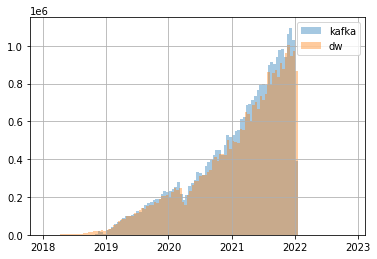

In [10]:
df_kafka.transaction_date.hist(bins=100, alpha=0.4, label="kafka")
df_dw.transaction_date.hist(bins=100, alpha=0.4, label="dw")
plt.legend()

#### slice by time

In [11]:
df_kafka.transaction_date.max(), df_dw.transaction_date.max()

(Timestamp('2022-11-16 00:00:00'), Timestamp('2022-01-18 00:00:00'))

In [39]:
%%time
# cutoff_date = min(df_kafka.transaction_date.max(), df_dw.transaction_date.max())
cutoff_date = pd.to_datetime("2022-01-05")  # already queried data wasn't available for one of the previous date
print(cutoff_date)
df_kafka_sliced = df_kafka[df_kafka.transaction_date <= cutoff_date]
df_dw_sliced = df_dw[df_dw.transaction_date <= cutoff_date]

2022-01-05 00:00:00
CPU times: user 9.09 s, sys: 2.15 s, total: 11.2 s
Wall time: 11.2 s


In [40]:
df_kafka_sliced.shape, df_dw_sliced.shape

((29560034, 17), (29722515, 12))

#### build unique ids

In [41]:
df_kafka_sliced["transeq"].isna().value_counts()

False    29560034
Name: transeq, dtype: int64

In [42]:
df_dw_sliced["transeq"].isna().value_counts()

False    29722515
Name: transeq, dtype: int64

In [43]:
"id" in df_kafka_sliced.columns, "id" in df_dw_sliced.columns

(False, False)

In [44]:
def get_id(df):
    id_series = df["business_account_number"].astype(int).astype(str) + "-" + df["transeq"].astype(int).astype(str)
    return id_series

df_kafka_sliced["id"] = get_id(df_kafka_sliced)
df_dw_sliced["id"] = get_id(df_dw_sliced)

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
df_kafka_sliced["id"].nunique(), df_kafka_sliced.shape

(28990022, (29560034, 18))

In [46]:
df_dw_sliced["id"].nunique(), df_dw_sliced.shape

(29722515, (29722515, 13))

In [47]:
kafka_ids = set(df_kafka_sliced["id"].unique())
dw_ids = set(df_dw_sliced["id"].unique())
print(len(kafka_ids.intersection(dw_ids)))
print(len(kafka_ids.union(dw_ids)))

2000
58710537


In [48]:
kafka_ban = set(df_kafka_sliced["business_account_number"].unique())
df_ban = set(df_dw_sliced["business_account_number"].unique())
print(len(kafka_ban.intersection(df_ban)))
print(len(kafka_ban.union(df_ban)))

307436
308683


In [49]:
list(kafka_ids)[:5]

['410007605968-803001',
 '410000215989-11017001',
 '410014314293-4040002',
 '410000198349-10264001',
 '410003819415-4083001']

In [50]:
list(dw_ids)[:5]

['410010785982-58',
 '410000220836-884',
 '410003967065-2385',
 '410004142648-967',
 '410012034803-122']

In [51]:
df_kafka_sliced.to_parquet("../../artifacts/data-dump/kafka-trnx-sliced-til-20220105.parquet")
df_dw_sliced.to_parquet("../../artifacts/data-dump/dw-trnx-sliced-til-20220105.parquet")